# Glider

In [1]:
import iris

iris.FUTURE.netcdf_promote = True

url = ('http://tds.marine.rutgers.edu:8080/thredds/dodsC/'
       'cool/glider/mab/Gridded/20130911T000000_20130920T000000_gp2013_modena.nc')

glider = iris.load(url)

lon = glider.extract_strict('Longitude').data
lat = glider.extract_strict('Latitude').data
glider = glider.extract_strict('Temperature')
depth = glider.coord('depth').points

/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1301: UserWarning: Ignoring netCDF variable 'salinity' invalid units 'psu'
  warnings.warn(msg.format(msg_name, msg_units))


In [2]:
import numpy as np
import numpy.ma as ma
import seawater as sw
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from utilities import time_coord

%matplotlib inline


def plot_glider(cube, mask_topo=False, track_inset=False, **kw):
    """Plot glider cube."""
    cmap = kw.pop('cmap', plt.cm.rainbow)
    
    data = ma.masked_invalid(cube.data.squeeze())
    t = time_coord(cube)
    #t = t.units.num2date(t.points.squeeze())
    
    dist, pha = sw.dist(lat, lon, units='km')
    dist = np.r_[0, np.cumsum(dist)]
    
    dist, z = np.broadcast_arrays(dist[..., None], depth)

    try:
        z_range = cube.coord(axis='Z').attributes['actual_range']
    except KeyError:
        z_range = z.min(), z.max()
    try:
        data_range = cube.attributes['actual_range']
    except KeyError:        
        data_range = data.min(), data.max()
    
    condition = np.logical_and(data >= data_range[0], data <= data_range[1])
    data = ma.masked_where(~condition, data)
    
    condition = np.logical_and(z >= z_range[0], z <= z_range[1])
    z = ma.masked_where(~condition, z)

    fig, ax = plt.subplots(figsize=(9, 3.75))
    cs = ax.pcolor(dist, z, data, cmap=cmap, snap=True, **kw)
    if mask_topo:
        h = z.max(axis=1)
        x = dist[:, 0]
        ax.plot(x, h, color='black', linewidth='0.5', zorder=3)
        ax.fill_between(x, h, y2=h.max(), color='0.9', zorder=3)
    #ax.set_title('Glider track from {} to {}'.format(t[0], t[-1]))
    fig.tight_layout()
    
    if track_inset:
        axin = inset_axes(ax, width="25%", height="30%", loc=4)
        axin.plot(lon, lat, 'k.')
        start, end = (lon[0], lat[0]), (lon[-1], lat[-1])
        kw = dict(marker='o', linestyle='none')
        axin.plot(*start, color='g', **kw)
        axin.plot(*end, color='r', **kw)
        axin.axis('off')
    return fig, ax, cs

# Models

In [3]:
from utilities import CF_names, quick_load_cubes

models = dict(useast=('http://ecowatch.ncddc.noaa.gov/thredds/dodsC/'
                      'ncom_us_east_agg/US_East_Apr_05_2013_to_Current_best.ncd'),
              hycom=('http://ecowatch.ncddc.noaa.gov/thredds/dodsC/'
                     'hycom/hycom_reg1_agg/HYCOM_Region_1_Aggregation_best.ncd'),
              sabgom=('http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/'
                      'fmrc/sabgom/SABGOM_Forecast_Model_Run_Collection_best.ncd'),
              coawst=('http://geoport.whoi.edu/thredds/dodsC/'
                      'coawst_4/use/fmrc/coawst_4_use_best.ncd'))


name_list = CF_names['sea_water_temperature']

coawst = quick_load_cubes(models['coawst'], name_list, strict=True)
useast = quick_load_cubes(models['useast'], name_list, strict=True)
hycom = quick_load_cubes(models['hycom'], name_list, strict=True)

/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/iris/fileformats/cf.py:1040: UserWarning: Ignoring formula terms variable u'h' referenced by data variable u'v' via variable u's_rho': Dimensions (u'eta_rho', u'xi_rho') do not span (u'time', u's_rho', u'eta_v', u'xi_v')
  warnings.warn(msg)
/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/iris/fileformats/cf.py:1040: UserWarning: Ignoring formula terms variable u'zeta' referenced by data variable u'v' via variable u's_rho': Dimensions (u'time', u'eta_rho', u'xi_rho') do not span (u'time', u's_rho', u'eta_v', u'xi_v')
  warnings.warn(msg)
/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/iris/fileformats/cf.py:1040: UserWarning: Ignoring formula terms variable u'h' referenced by data variable u'u' via variable u's_rho': Dimensions (u'eta_rho', u'xi_rho') do not span (u'time', u's_rho', u'eta_u', u'xi_u')
  warnings.warn(msg)
/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/iris/fileformats/cf.py:104

In [4]:
from datetime import datetime
from utilities import proc_cube

# Glider info.
start = glider.coord(axis='T').attributes['minimum']
stop = glider.coord(axis='T').attributes['maximum']

start = datetime.strptime(start, '%Y-%m-%d %H:%M:%S') 
stop = datetime.strptime(stop, '%Y-%m-%d %H:%M:%S')

bbox = lon.min(), lat.min(), lon.max(), lat.max()

# Subsetting the cube to the glider limits.
coawst = proc_cube(coawst, bbox=bbox, time=(start, stop), units=glider.units)
useast = proc_cube(useast, bbox=bbox, time=(start, stop), units=glider.units)
hycom = proc_cube(hycom, bbox=bbox, time=(start, stop), units=glider.units)

coawst, useast, hycom

(<iris 'Cube' of sea_water_potential_temperature / (Celsius) (time: 209; ocean_s_coordinate_g1: 16; -- : 8; -- : 11)>,
 <iris 'Cube' of sea_water_temperature / (degC) (time: 69; depth: 40; latitude: 12; longitude: 14)>,
 <iris 'Cube' of sea_water_temperature / (degC) (time: 67; depth: 40; latitude: 5; longitude: 6)>)

In [5]:
for aux in coawst.aux_factories:
    coawst.remove_aux_factory(aux)

In [6]:
from iris.analysis import trajectory

sample_points = [('latitude', lat),
                 ('longitude', lon),
                 ('time', glider.coord(axis='T').points)]

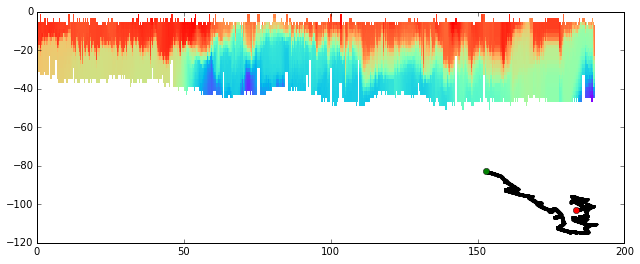

In [7]:
depth = glider.coord('depth').points
fig, ax, cs = plot_glider(glider, mask_topo=False, track_inset=True)

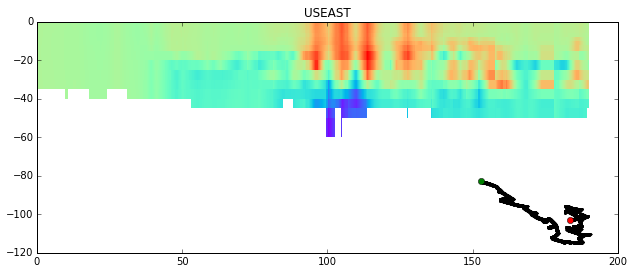

In [8]:
iuseast = trajectory.interpolate(useast, sample_points)
iuseast.transpose()

depth = -iuseast.coord(axis='Z').points

fig, ax, cs = plot_glider(iuseast, mask_topo=False, track_inset=True)
ax.set_ylim(-120, 0)
t = ax.set_title("USEAST")

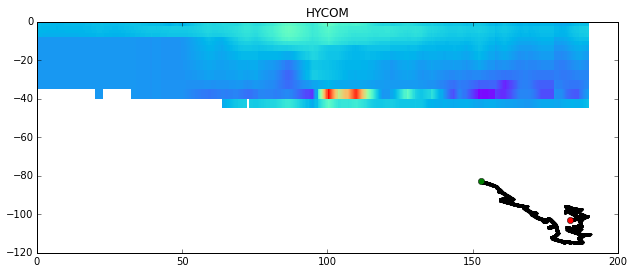

In [9]:
ihycom = trajectory.interpolate(hycom, sample_points)
ihycom.transpose()

depth = -ihycom.coord(axis='Z').points

fig, ax, cs = plot_glider(ihycom, mask_topo=False, track_inset=True)
ax.set_ylim(-120, 0)
t = ax.set_title("HYCOM")

In [10]:
icoawst = trajectory.interpolate( coawst, sample_points)

icoawst.transpose()

depth = -icoawst.coord(axis='Z').points

fig, ax, cs = plot_glider(ihycom, mask_topo=False, track_inset=True)
ax.set_ylim(-120, 0)
t = ax.set_title("COAWST")

KeyboardInterrupt: 